In [1]:
using Revise
using LinearAlgebra
using MatrixMarket
using EAMC
using SparseArrays
using Plots
using Interact

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1273
┌ Info: Precompiling EAMC [d0d32b4c-83b1-4490-9109-c03fdd3b1e42]
└ @ Base loading.jl:1273
┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5889149917236016050\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-18297674727106902135\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5889149917236016050\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
end;

In [51]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q = q * 0.36
    q .- Diagonal(sum(q, dims=2)|>vec) # mass conservation
end;

In [52]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
dt[end] = 1000
tmax = length(qs)
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  3.212560 seconds (10.10 k allocations: 4.566 GiB, 6.09% gc time)


In [53]:
cs = EAMC.commitors(g, 900)

21600×900 Array{Float64,2}:
 0.0866489  0.127357   0.185268  0.251107  …  6.06552e-53  -3.15169e-60
 0.0842294  0.124231   0.182482  0.25046      1.14534e-52  -5.96314e-60
 0.0810862  0.120054   0.178691  0.249463     2.24245e-52  -1.16943e-59
 0.0786931  0.116636   0.175457  0.248389     4.74506e-52  -2.47952e-59
 0.076478   0.113207   0.172086  0.247051     1.11433e-51  -5.83358e-59
 0.0744287  0.109688   0.168481  0.245374  …  2.80867e-51  -1.4725e-58 
 0.0729641  0.106718   0.165283  0.243631     7.56053e-51  -3.96888e-58
 0.0726732  0.1053     0.163535  0.242337     2.1852e-50   -1.14841e-57
 0.0739415  0.105875   0.163649  0.241637     6.70455e-50  -3.52645e-57
 0.0765683  0.107486   0.164544  0.240845     2.03151e-49  -1.06916e-56
 0.0808043  0.108847   0.16464   0.238677  …  6.00905e-49  -3.16664e-56
 0.0865085  0.106258   0.159721  0.232101     4.985e-49    -2.56109e-56
 0.100617   0.0981839  0.146178  0.215102     2.91535e-49  -1.42984e-56
 ⋮                                  

In [54]:
cc = reshape(cs, 30, 30, 24, 30, 30)

30×30×24×30×30 Array{Float64,5}:
[:, :, 1, 1, 1] =
 0.0866489   0.0866291    0.0868959   …  0.0470981   0.0304459   0.0178623 
 0.0842294   0.0843422    0.0849793      0.0323145   0.0225418   0.0148044 
 0.0810862   0.0814585    0.0826597      0.0155608   0.0121249   0.00876156
 0.0786931   0.0792521    0.0809483      0.007132    0.00573301  0.00454975
 0.076478    0.0773891    0.079673       0.00844182  0.00422201  0.00278415
 0.0744287   0.0758229    0.0792174   …  0.0169816   0.00694508  0.00331621
 0.0729641   0.0753266    0.0801366      0.0304789   0.0137944   0.00744538
 0.0726732   0.0764004    0.0820126      0.0515286   0.0305182   0.0197906 
 0.0739415   0.0785278    0.0842925      0.0791244   0.0517081   0.0375055 
 0.0765683   0.0812995    0.0869379      0.105536    0.0727002   0.0537472 
 0.0808043   0.0843375    0.0882999   …  0.126707    0.0914458   0.0666331 
 0.0865085   0.0876404    0.0896285      0.141887    0.107594    0.0788874 
 0.100617    0.0975056    0.0940877  

In [55]:
using Plots
@manipulate for x=slider(1:30, 15, label="x"), y=slider(1:30, 15, label="y"), t=slider(1:24, 1, label="t")
heatmap(cc[:,:,t,y,x], title="Commitor von (x=$x,y=$y,t=24) zum zeitpunkt t=$t")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["x"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 30,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
15, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000110889210, Task (runnable) @0x0000000110889210), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":15,\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"10671542842773275887\",\"id\":\"ob_56\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"10671542842773275887\",\"id\":\"ob_55\",\"type\":\"observable\"})};\n  

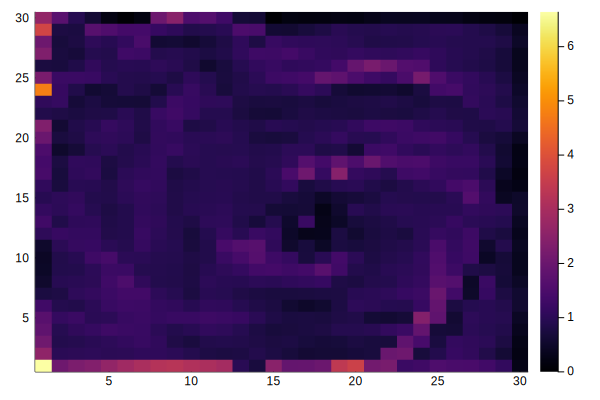

In [56]:
sc = sum(cc[:,:,23,:,:], dims=[1,2]) |> x->reshape(x, 30,30)
heatmap(sc)

In [74]:
## restrict clustering area to the center
tcluster = 12 # timepoint at which to seperate the clusters
xmin, xmax, ymin, ymax = 1,30,1,30
M = reshape(cc[xmin:xmax, ymin:ymax, tcluster, xmin:xmax, ymin:ymax], 30*30*1, 30*30)
#css = css ./ sqrt.(sum(css, dims=1))
#M = reshape(cc[:,:,12,:,:], 30*30, 30*30)

M = M' * M
M = M - Diagonal(M)
M = M ./ sum(M, dims=2);

In [75]:
include("src/pccap.jl")
nc = 4
p = pccap(M, nc)
# now sort by cluster size
p = p[:,sortperm(sum(p, dims=1)|>vec, rev=true)];

In [76]:
cl = reshape(cc[:,:,:, xmin:xmax, ymin:ymax], 30*30*24, 30*30) * p
cl = reshape(cl, 30, 30, 24, nc);

In [77]:
using Interact
c = 3
gr()
@manipulate for i = 1:24, c=1:nc
heatmap(log.(cl[:,:,i,c].+1), title="pccap on center, t=$i", clims=(0,.3))
    end

@manipulate for i = 1:24, c=1:nc
heatmap(cl[:,:,i,c], title="pccap on center, t=$i")
    end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000128771b10, Task (runnable) @0x0000000128771b10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"4955165909067153908\",\"id\":\"ob_

┌ Info: Saved animation to 
│   fn = /Users/alex/Desktop/code/generators/tmp.gif
└ @ Plots /Users/alex/.julia/packages/Plots/RsO3g/src/animation.jl:98


Plots.AnimatedGif("/Users/alex/Desktop/code/generators/tmp.gif")
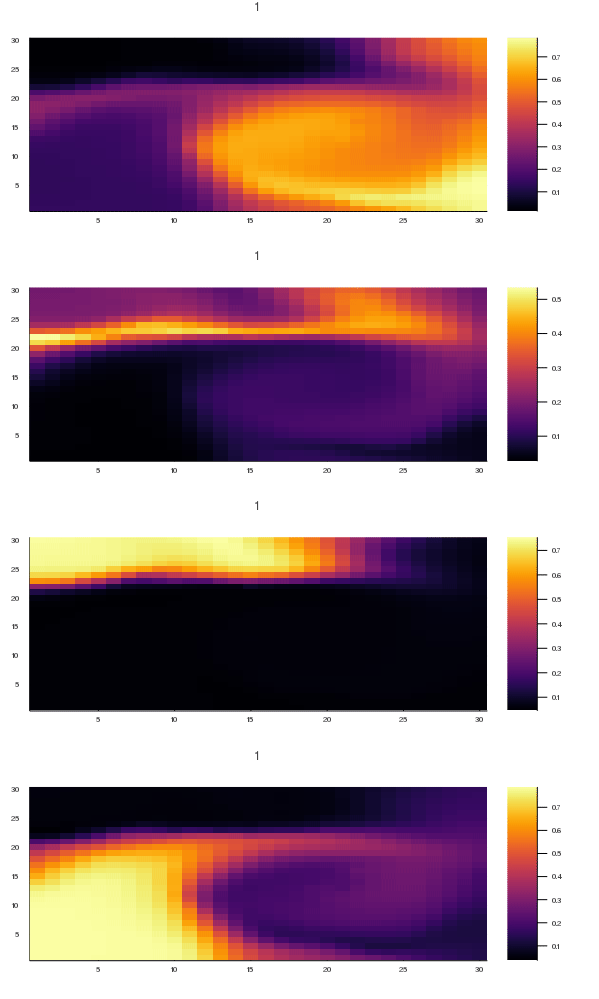

In [113]:

anim = @animate for t=1:24
plot([heatmap(cl[:,:,t,c]) for c=1:4]..., layout=grid(4,1), size=(600,1000), title="$t")
end

gif(anim, fps=6)